# Datasets using `tf.data.Dataset`

## Test example

Once the feedloop is setup as a python generator, it can be converted in to a tensorflow `Dataset` object for optimal ingestion into Keras. We exemplify this here, using a generator that reads tiles in TIFF format from disk:

In [1]:
import pathlib
import tensorflow as tf
import xarray as xr

In [2]:
# path with TIFF files
tile_path = "./retiled_test"

In [3]:
# generator - much simplified version of the feed loop, reading cutouts from disk
def get_tile(tile_path):
    # string input is passed by tf as byte object, need to decode
    tile_path = tile_path.decode() if isinstance(tile_path, bytes) else tile_path
    tile_path = pathlib.Path(tile_path)
    for file in tile_path.glob("*.tif"):
        yield xr.open_rasterio(file).data

In [4]:
# testing the iterator
iterator = get_tile(tile_path)
element = next(iterator)
element.dtype, element.shape

(dtype('uint16'), (3, 20, 20))

In [5]:
# set up Dataset object
ds = tf.data.Dataset.from_generator(
    get_tile, 
    args=[tile_path], 
    output_types=tf.int16, 
    output_shapes=(3, 20, 20)
)
ds

<FlatMapDataset shapes: (3, 20, 20), types: tf.int16>

In [6]:
# shuffle elements with a buffer of 100, making batches with 20 cutouts each
# (in first batch we can have elements from the first 120 files)
batches = ds.shuffle(buffer_size=100).batch(20, drop_remainder=True)
batches

<BatchDataset shapes: (20, 3, 20, 20), types: tf.int16>

## Feed loop for VAE network

We implement the real feedloop using `xarray`:

In [1]:
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr

from memory_profiler import memory_usage

In [2]:
class Dataset:
    
    def __init__(self, tile_list, cutout_size, offset=0, stride=None, num_tiles=None, shuffle_tiles=False):
        self.cutout_size = cutout_size
        self.stride = stride if stride is not None else self.cutout_size
        _num_tiles = num_tiles if num_tiles is not None else len(tile_list)
        self.tiles = random.sample(tile_list, _num_tiles) if shuffle_tiles else tile_list[:_num_tiles]
        if offset >= cutout_size:
            raise ValueError(
                "offset larger than window size - set "
                "offset to {}".format(sizeCutOut%offset)
            )
        self.offset = offset
    
    def set_mask(self, shapefile, invert=False):
        """ Mask a selection of the pixels using a shapefile. """
        raise NotImplementedError()
    
    def to_tf(self):
        """ Obtain dataset as a tensorflow `Dataset` object. """
        ds = tf.data.Dataset.from_generator(
            self._generate_cutouts,  
            output_types=(tf.float64, tf.float64, tf.float32), 
            output_shapes=(
                None,  # x
                None,  # y
                (None, None, self.cutout_size, self.cutout_size)  # samples, bands, x_win, y_win
            )
        )
        return ds.flat_map(lambda x,y,z: tf.data.Dataset.from_tensor_slices((x,y,z)))

    def _generate_cutouts(self):
        """ 
        Iterate over (a selection of) the tiles yielding all 
        cutouts for each of them.
        """
        for tile in self.tiles:
            
            print(f"Reading tile {tile}!")
            
            # read tile
            da = xr.open_rasterio(tile)
            
            # TODO: apply mask here?
            
            # apply offset
            da = da.shift(x=self.offset, y=self.offset)  # only shift data, not coords
            da['x'] = da.x.shift(x=self.offset)
            da['y'] = da.y.shift(y=self.offset)

            # generate windows
            da = da.rolling(x=self.cutout_size, y=self.cutout_size)
            da = da.construct({'x': 'x_win', 'y': 'y_min'}, stride=self.stride)

            # drop NaN-containing windows
            da = da.stack(sample=('x', 'y'))
            da = da.dropna(dim='sample', how='any')
            yield (da.sample.coords['x'], 
                   da.sample.coords['y'], 
                   da.data.transpose(3, 0, 1, 2))  # samples, bands, x_win, y_win

In [3]:
# list of all tiles available
tile_list = [t for t in pathlib.Path('./test').glob('tile_*.tif')]
len(tile_list)

20

In [4]:
ds = Dataset(
    tile_list=tile_list,
    cutout_size=20,
)
dataset = ds.to_tf()
dataset

<FlatMapDataset shapes: (<unknown>, <unknown>, (None, 20, 20)), types: (tf.float64, tf.float64, tf.float32)>

In [5]:
batches = dataset.shuffle(buffer_size=500000).batch(250000, drop_remainder=True)
batches

<BatchDataset shapes: (<unknown>, <unknown>, (250000, None, 20, 20)), types: (tf.float64, tf.float64, tf.float32)>

In [6]:
def run(batches):
    for x, y, data in batches:
        print(x.shape, y.shape, data.shape)

# run(batches)

In [7]:
%%time
memory = memory_usage((run, (batches,)), interval=0.01)

Reading tile test/tile_1.tif!
Reading tile test/tile_3.tif!
Reading tile test/tile_18.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_2.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_19.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_6.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_7.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_20.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_5.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_4.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_9.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_12.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_8.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_13.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_11.tif!
(250000,) (250000,) (250000, 3, 20, 20)
Reading tile test/tile_1

Text(0.5, 0, 'Time step')

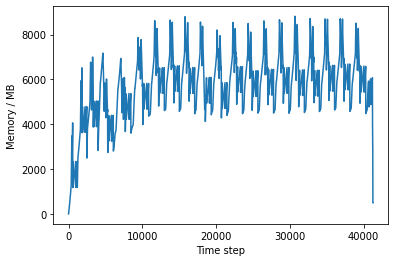

In [8]:
_memory = np.array(memory) - memory[0]
plt.plot(_memory)
plt.ylabel("Memory / MB")
plt.xlabel("Time step")